Project : Recency of sales and resell within Brazil Public e-commerce dataset by Olist [Kaggle dataset]

The bases were taken from the kaggle dataset: Brazil Public e-commerce dataset by Olist:https://www.kaggle.com/olistbr/brazilian-ecommerce



In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#loading the bases

df_orders = pd.read_csv('/content/drive/MyDrive/projeto-ibm-datasets/olist/input/olist_orders_dataset.csv', parse_dates=['order_approved_at'])
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [ ]:
df_order_items = pd.read_csv('/content/drive/MyDrive/projeto-ibm-datasets/olist/input/olist_order_items_dataset.csv')
df_order_items.head()


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
df_sellers = pd.read_csv('/content/drive/MyDrive/projeto-ibm-datasets/olist/input/olist_sellers_dataset.csv')
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


# Creating the ABT Classification

Here we will go to our ABT using only 1 harvest, which is the harvest with reference date 2018-01-01.
As we will use a history of 18 months, with the first 12 months to build the features and the last 6 months to build the target variable, we then have that the lower deadline corresponds to the reference date subtracted from 12 months, that is, 2017 -01-01. 
The upper limit date corresponds to the reference date added of 6 months, 2018-07-01 (exclusive).

In [ ]:
df_historico_abt_train = (
    df_order_items
    .merge(df_orders, on='order_id', how='left')
    .query('order_status == "delivered"')
    .query('order_approved_at >= "2017-01-01" & order_approved_at < "2018-07-01"')
    .merge(df_sellers, on='seller_id', how='left')
)
df_historico_abt_train.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,seller_zip_code_prefix,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,27277,volta redonda,SP
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,3471,sao paulo,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,37564,borda da mata,MG
3,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.9,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,87900,loanda,PR
4,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.9,12.69,816cbea969fe5b689b39cfc97a506742,delivered,2017-05-15 21:42:34,2017-05-17 03:55:27,2017-05-17 11:05:55,2017-05-22 13:44:35,2017-06-06 00:00:00,14091,ribeirao preto,SP


In [ ]:
# creating features
df_features_train = (
    df_historico_abt_train
    .query('order_approved_at < "2018-01-01"')
    .groupby('seller_id')
    .agg(uf = ('seller_state', 'first'),
         tot_orders_12m = ('order_id', 'nunique'),
         tot_items_12m = ('product_id', 'count'),
         tot_items_dist_12m = ('product_id', 'nunique'),
         receita_12m = ('price', 'sum'),
         data_ult_vnd = ('order_approved_at', 'max'))
    .reset_index()   
    .assign(data_ref = pd.to_datetime('2018-01-01 00:00:00'))
    .assign(recencia = lambda df: (df['data_ref'] - df['data_ult_vnd']).dt.days)
)
df_features_train.head()

,seller_id,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,data_ult_vnd,data_ref,recencia
0,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,3,1,2685.00,2017-10-18 23:56:20,2018-01-01,74
1,001cca7ae9ae17fb1caed9dfb1094831,ES,171,207,9,21275.23,2017-12-29 02:09:49,2018-01-01,2
2,002100f778ceb8431b7a1020ff7ab48f,SP,38,42,15,781.80,2017-12-29 02:10:04,2018-01-01,2
3,003554e2dce176b5555353e4f3555ac8,GO,1,1,1,120.00,2017-12-15 07:11:03,2018-01-01,16
4,004c9cd9d87a3c30c522c48c4fc07416,SP,130,141,75,16228.88,2017-12-23 21:49:44,2018-01-01,8


In [ ]:
# creating target
df_target_train = (
    df_historico_abt_train
    .query('order_approved_at >= "2018-01-01" & order_approved_at < "2018-07-01"')
    .filter(['seller_id'])
    .drop_duplicates()
)
df_target_train.head()

,seller_id
2,5b51032eddd242adc84c38acab88f23d
6,a416b6a846a11724393025641d4edd5e
7,cc419e0650a3c5ba77189a1882b7556a
8,1f50f920176fa81dab994f9023523100
10,fcb5ace8bcc92f75707dc0f01a27d269


In [ ]:
# creating the abt of fact
df_abt_train = (
    df_features_train
    .merge(df_target_train, on='seller_id', how='left', indicator=True)
    # left_only = churn (1), both = não churn (0)
    .assign(nao_revendeu_next_6m = lambda df: np.where(df['_merge'] == "left_only", 1, 0))
    .filter(['data_ref', 
             'seller_id',
             'uf',
             'tot_orders_12m',
             'tot_items_12m',
             'tot_items_dist_12m',
             'receita_12m',
             'recencia',
             'nao_revendeu_next_6m'])
)
df_abt_train.head()

,data_ref,seller_id,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,nao_revendeu_next_6m
0,2018-01-01,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,3,1,2685.00,74,1
1,2018-01-01,001cca7ae9ae17fb1caed9dfb1094831,ES,171,207,9,21275.23,2,0
2,2018-01-01,002100f778ceb8431b7a1020ff7ab48f,SP,38,42,15,781.80,2,0
3,2018-01-01,003554e2dce176b5555353e4f3555ac8,GO,1,1,1,120.00,16,1
4,2018-01-01,004c9cd9d87a3c30c522c48c4fc07416,SP,130,141,75,16228.88,8,0


In [ ]:
#exploratory analysis
#remove missing information
df = df_abt_train.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 0 to 1689
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   data_ref              1690 non-null   datetime64[ns]
 1   seller_id             1690 non-null   object        
 2   uf                    1690 non-null   object        
 3   tot_orders_12m        1690 non-null   int64         
 4   tot_items_12m         1690 non-null   int64         
 5   tot_items_dist_12m    1690 non-null   int64         
 6   receita_12m           1690 non-null   float64       
 7   recencia              1690 non-null   int64         
 8   nao_revendeu_next_6m  1690 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 132.0+ KB


In [ ]:
df_X = df.copy()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


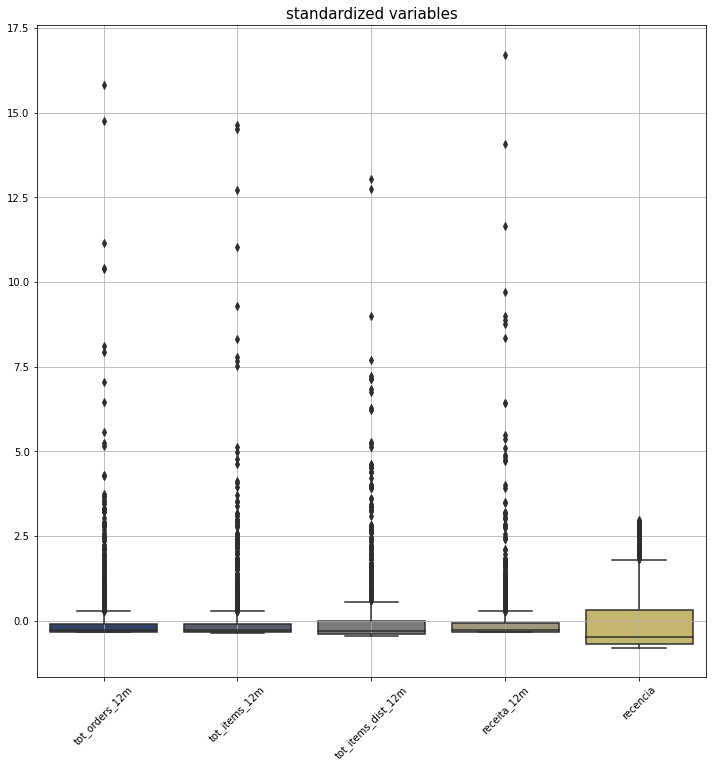

In [ ]:
#standardizing numeric variables
from sklearn.preprocessing  import  StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor

scaler = StandardScaler()

dependent_cols = df_X.drop(['receita_12m' ,'data_ref', 'seller_id', 'uf'], axis=1)
numerical_data1 = ['tot_orders_12m', 'tot_items_12m', 'tot_items_dist_12m', 'receita_12m', 'recencia']
numerical_data = df_X[numerical_data1]

transformed_x = scaler.fit_transform(numerical_data)
fig = plt.figure(figsize=(12,12))
ax = sns.boxplot(data=transformed_x, orient="v", palette="cividis")
ax.set_xticklabels(numerical_data1, rotation=45);
plt.title("standardized variables", fontsize=15)
ax.grid()

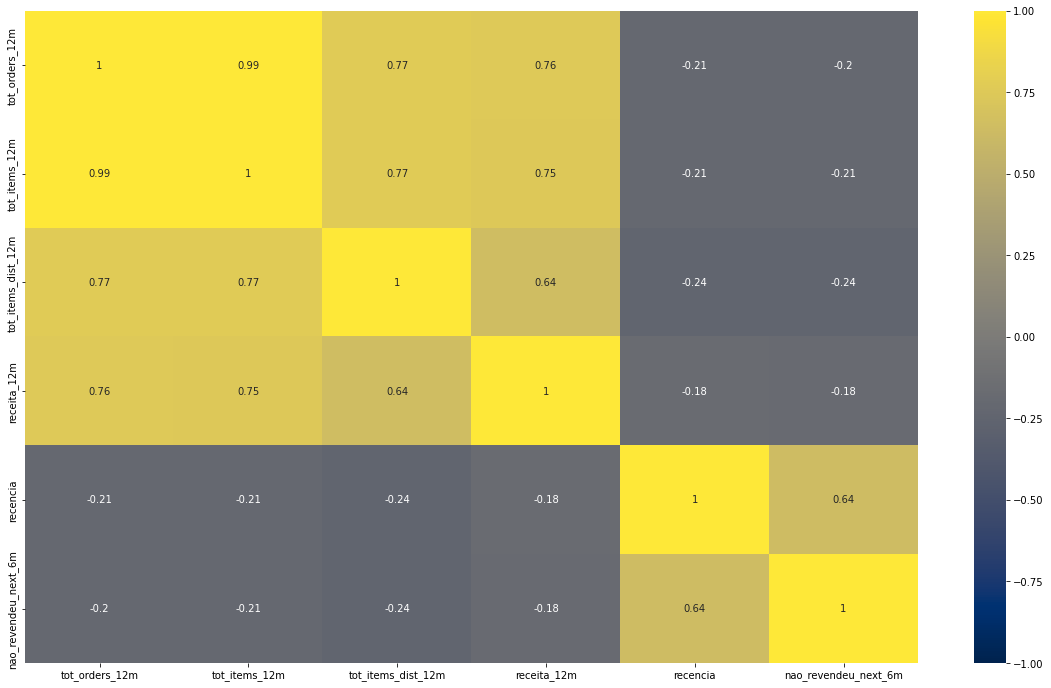

In [ ]:
plt.figure(figsize=(20, 12))
sns.heatmap(df_X.corr(), annot=True,vmin=-1, vmax=1,center= 0, cmap='cividis')
plt.show()

In [ ]:
#pre-modeling
#creating many haverts

import dateutil

df_abt_safras = pd.DataFrame()
for safra in ['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01']:
    data_ref_safra     = pd.to_datetime(safra).date()
    data_inf_inclusiva = data_ref_safra - dateutil.relativedelta.relativedelta(months=12)
    data_sup_exclusiva = data_ref_safra + dateutil.relativedelta.relativedelta(months=6)  
    #print(f"Data Ref: {data_ref_safra}; Data Inf: {data_inf_inclusiva}; Data Sup: {data_sup_exclusiva}")

    df_historico_abt = (
        df_order_items
        .merge(df_orders, on='order_id', how='inner')
        .query('order_status == "delivered"')
        .query(f'order_approved_at >= "{data_inf_inclusiva}" & order_approved_at < "{data_sup_exclusiva}"')
        .merge(df_sellers, on='seller_id', how='left')
    )

    df_features = (
        df_historico_abt
        .query(f'order_approved_at < "{data_ref_safra}"')
        .groupby('seller_id')
        .agg(uf                 = ('seller_state', 'first'),
             tot_orders_12m     = ('order_id', 'nunique'),
             tot_items_12m      = ('product_id', 'count'),
             tot_items_dist_12m = ('product_id', 'nunique'),
             receita_12m        = ('price', 'sum'),
             data_ult_vnd       = ('order_approved_at', 'max'))
        .reset_index()
        .assign(data_ref_safra = pd.to_datetime(f'{data_ref_safra}'))
        .assign(recencia = lambda df: (df['data_ref_safra'] - df['data_ult_vnd']).dt.days)
    )
    
    df_target = (
        df_historico_abt_train
        .query(f'order_approved_at >= "{data_ref_safra}" & order_approved_at < "{data_sup_exclusiva}"')
        .filter(['seller_id'])
        .drop_duplicates()
    )

    df_abt = (
        df_features
        .merge(df_target, how='left', on='seller_id', indicator=True)
        .assign(nao_revendeu_next_6m = lambda df: np.where(df['_merge'] == "left_only", 1, 0))
        .filter(['data_ref_safra', 'seller_id', 'uf', 'tot_orders_12m', 'tot_items_12m', 'tot_items_dist_12m', 'receita_12m', 'recencia', 'nao_revendeu_next_6m'])
    )

    df_abt_safras = pd.concat([df_abt_safras, df_abt])

In the previous code only one crop was created. But a seller can have its profile changed, or have changes in the market. A seller who in March 2018 was selling well, household appliances, in April may sell more clothes, or not. This behavior change can be captured for the machine learning algorithm to learn from various seasons in the training base.


In [ ]:
(
    df_abt_safras
    .groupby('data_ref_safra')
    .agg(prop_nao_revenderam = ('nao_revendeu_next_6m', 'mean'))
)

,prop_nao_revenderam
data_ref_safra,
2018-01-01,0.376331
2018-02-01,0.395568
2018-03-01,0.411419
2018-04-01,0.435858
2018-05-01,0.471008
2018-06-01,0.558066


In [ ]:
key_vars = ['data_ref_safra', 'seller_id']
num_vars = ['tot_orders_12m', 'tot_items_12m', 'tot_items_dist_12m', 'receita_12m', 'recencia']
cat_vars = ['uf']
target = 'nao_revendeu_next_6m'

features = cat_vars + num_vars

In [ ]:
# traing
df_train = df_abt_safras.query('data_ref_safra < "2018-03-01"')

# test
df_oot   = df_abt_safras.query('data_ref_safra == "2018-03-01"')

# data of train
X_train = df_train[features]
y_train = df_train[target]

# data out of time
X_oot = df_oot[features]
y_oot = df_oot[target]

In [ ]:
!pip install pycaret[full]==2.3.1

In [ ]:
from pycaret.classification import *

In [ ]:
exp_setup = setup(data=df_train, test_data=df_oot, target=target,
                  ignore_features=key_vars, categorical_features=cat_vars, numeric_features=num_vars, session_id=42)

,Description,Value
0,session_id,42
1,Target,nao_revendeu_next_6m
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(3495, 9)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
help(get_config)

Help on function get_config in module pycaret.classification:

get_config(variable: str)
    This function retrieves the global variables created when initializing the 
    ``setup`` function. Following variables are accessible:
    
    - X: Transformed dataset (X)
    - y: Transformed dataset (y)  
    - X_train: Transformed train dataset (X)
    - X_test: Transformed test/holdout dataset (X)
    - y_train: Transformed train dataset (y)
    - y_test: Transformed test/holdout dataset (y)
    - seed: random state set through session_id
    - prep_pipe: Transformation pipeline
    - fold_shuffle_param: shuffle parameter used in Kfolds
    - n_jobs_param: n_jobs parameter used in model training
    - html_param: html_param configured through setup
    - create_model_container: results grid storage container
    - master_model_container: model storage container
    - display_container: results display container
    - exp_name_log: Name of experiment
    - logging_param: log_experiment par

In [ ]:
get_config('X')

,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,uf_AM,uf_BA,uf_CE,uf_DF,uf_ES,uf_GO,uf_MA,uf_MG,uf_MS,uf_MT,uf_PA,uf_PB,uf_PE,uf_PI,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RS,uf_SC,uf_SE,uf_SP
0,3.0,3.0,1.0,2685.000000,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,171.0,207.0,9.0,21275.230469,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38.0,42.0,15.0,781.799988,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,1.0,120.000000,16.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,130.0,141.0,75.0,16228.879883,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,10.0,10.0,5.0,9976.799805,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1801,2.0,2.0,2.0,84.800003,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1802,8.0,9.0,7.0,1254.099976,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1803,10.0,10.0,2.0,1359.900024,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
get_config('prep_pipe')

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['uf'],
                                      display_types=True,
                                      features_todrop=['data_ref_safra',
                                                       'seller_id'],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['tot_orders_12m',
                                                          'tot_items_12m',
                                                          'tot_items_dist_12m',
                                                          'receita_12m',
                                                          'recencia'],
                                      target='nao_revendeu_next_6m',
                                      time_features=[])),
                ('impu...
                ('scaling', 'passthr

In [ ]:
#trainning many models with pycaret

compare_models(fold=5, sort='auc')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8589,0.9232,0.7800,0.8438,0.8105,0.6984,0.7000,0.692
rf,Random Forest Classifier,0.8529,0.9215,0.7807,0.8291,0.8040,0.6865,0.6875,0.752
xgboost,Extreme Gradient Boosting,0.8526,0.9193,0.8000,0.8155,0.8075,0.6882,0.6884,4.240
catboost,CatBoost Classifier,0.8458,0.9170,0.7822,0.8122,0.7966,0.6725,0.6731,2.978
lightgbm,Light Gradient Boosting Machine,0.8383,0.9133,0.7793,0.7977,0.7882,0.6575,0.6578,0.172
gbc,Gradient Boosting Classifier,0.8389,0.9112,0.7711,0.8043,0.7872,0.6577,0.6582,0.386
ada,Ada Boost Classifier,0.8263,0.8998,0.7556,0.7871,0.7706,0.6310,0.6318,0.200
lr,Logistic Regression,0.8200,0.8972,0.6533,0.8460,0.7371,0.6037,0.6155,0.730
lda,Linear Discriminant Analysis,0.8103,0.8969,0.5844,0.8858,0.7041,0.5730,0.5999,0.032
nb,Naive Bayes,0.5557,0.8658,0.9474,0.4635,0.6224,0.2151,0.3062,0.026


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [ ]:
compare_models_results = pull()
compare_models_results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8589,0.9232,0.7800,0.8438,0.8105,0.6984,0.7000,0.692
rf,Random Forest Classifier,0.8529,0.9215,0.7807,0.8291,0.8040,0.6865,0.6875,0.752
xgboost,Extreme Gradient Boosting,0.8526,0.9193,0.8000,0.8155,0.8075,0.6882,0.6884,4.240
catboost,CatBoost Classifier,0.8458,0.9170,0.7822,0.8122,0.7966,0.6725,0.6731,2.978
lightgbm,Light Gradient Boosting Machine,0.8383,0.9133,0.7793,0.7977,0.7882,0.6575,0.6578,0.172
gbc,Gradient Boosting Classifier,0.8389,0.9112,0.7711,0.8043,0.7872,0.6577,0.6582,0.386
ada,Ada Boost Classifier,0.8263,0.8998,0.7556,0.7871,0.7706,0.6310,0.6318,0.200
lr,Logistic Regression,0.8200,0.8972,0.6533,0.8460,0.7371,0.6037,0.6155,0.730
lda,Linear Discriminant Analysis,0.8103,0.8969,0.5844,0.8858,0.7041,0.5730,0.5999,0.032
nb,Naive Bayes,0.5557,0.8658,0.9474,0.4635,0.6224,0.2151,0.3062,0.026


In [ ]:
et = create_model('et', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8512,0.9285,0.7852,0.8217,0.8030,0.6836,0.6840
1,0.8426,0.9238,0.7778,0.8077,0.7925,0.6658,0.6661
2,0.8641,0.9112,0.7741,0.8601,0.8148,0.7079,0.7104
3,0.8684,0.9240,0.7778,0.8678,0.8203,0.7170,0.7196
4,0.8684,0.9284,0.7852,0.8618,0.8217,0.7178,0.7197
Mean,0.8589,0.9232,0.7800,0.8438,0.8105,0.6984,0.7000
SD,0.0103,0.0063,0.0044,0.0243,0.0112,0.0205,0.0214
